# Decision Trees - AAPL Microstructure Prediction

**Objective:** Train Decision Tree classifiers with hyperparameter tuning and compare against baseline logistic regression.

**Inputs:**

- Features with regimes from notebook 30 (`AAPL_features_with_regimes.parquet`)
- Baseline results from notebook 35

**Models:**

- Decision Tree with Gini impurity
- Decision Tree with Entropy criterion
- Hyperparameter tuning: max_depth, min_samples_split, min_samples_leaf

**Outputs:**

- Tuned Decision Tree models
- Performance comparison vs. baseline
- Decision path visualizations
- Feature importance analysis
- Depth saturation analysis

**Target Variable:** Next-period mid-price direction (up=1, down=0)


## 1. Setup and Imports


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import json
import warnings

warnings.filterwarnings("ignore")

# Sklearn imports
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
)

# Visualization
plt.style.use("seaborn-v0_8-paper")
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.weight": "bold",
        "axes.labelweight": "bold",
        "axes.titleweight": "bold",
        "axes.linewidth": 1.2,
        "axes.spines.top": False,
        "axes.spines.right": False,
    }
)

# Import project config
import sys

sys.path.append("..")
from src.config import PROCESSED_DATA_DIR, MODELS_DIR, FIGURES_DIR, TABLES_DIR

# Create output directories
dt_dir = FIGURES_DIR / "decision_trees"
dt_dir.mkdir(parents=True, exist_ok=True)

# Set random seed
np.random.seed(42)

print("✓ Setup complete")
print(f"  Data directory: {PROCESSED_DATA_DIR}")
print(f"  Models directory: {MODELS_DIR}")
print(f"  Figures directory: {dt_dir}")

✓ Setup complete
  Data directory: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../data/processed
  Models directory: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../models
  Figures directory: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/decision_trees


## 2. Load Data


In [ ]:
# Load features with regimes from notebook 30
print("Loading features with regimes...")
features_with_regimes = pd.read_parquet(
    PROCESSED_DATA_DIR / "AAPL_features_with_regimes.parquet"
).reset_index(drop=True)

print(f"✓ Features with regimes: {features_with_regimes.shape}")
print(
    f"  Date range: {features_with_regimes['timestamp'].min()} to {features_with_regimes['timestamp'].max()}"
)
print(f"  Columns: {len(features_with_regimes.columns)}")

# Load baseline results for comparison
with open(MODELS_DIR / "baseline_results.json", "r") as f:
    baseline_results = json.load(f)

print("\n✓ Loaded baseline results")
print(f"  Baseline L2 test accuracy: {baseline_results['lr_l2']['test_accuracy']:.4f}")
print(f"  Baseline L2 test F1: {baseline_results['lr_l2']['test_f1']:.4f}")
print(f"  Baseline L2 test ROC-AUC: {baseline_results['lr_l2']['test_roc_auc']:.4f}")

Loading features with regimes...
✓ Features with regimes: (423, 94)
  Date range: 2024-12-09 14:40:00+00:00 to 2024-12-10 00:16:00+00:00
  Columns: 94

✓ Loaded baseline results
  Baseline L2 test accuracy: 0.5647
  Baseline L2 test F1: 0.5934
  Baseline L2 test ROC-AUC: 0.5931


## 3. Create Target Variable and Features


In [ ]:
# Find price column
price_candidates = ["agg_mid_price", "agg_close", "mid_price", "close"]
price_col = next(
    (col for col in price_candidates if col in features_with_regimes.columns), None
)

if price_col is None:
    raise ValueError(
        f"No price column found. Available columns: {features_with_regimes.columns.tolist()[:20]}"
    )

print(f"Using price column: {price_col}")

# Create target: 1 if next price > current price, 0 otherwise
features_with_regimes["price_next"] = features_with_regimes[price_col].shift(-1)
features_with_regimes["target"] = (
    features_with_regimes["price_next"] > features_with_regimes[price_col]
).astype(int)

# Remove last row (no future price)
features_with_regimes = features_with_regimes[:-1].copy()

print(f"\n✓ Target variable created")
print(f"  Shape after removing last row: {features_with_regimes.shape}")
print(f"\nTarget distribution:")
target_counts = features_with_regimes["target"].value_counts()
print(
    f"  Down (0): {target_counts.get(0, 0):,} ({100*target_counts.get(0, 0)/len(features_with_regimes):.1f}%)"
)
print(
    f"  Up (1): {target_counts.get(1, 0):,} ({100*target_counts.get(1, 0)/len(features_with_regimes):.1f}%)"
)

Using price column: agg_mid_price

✓ Target variable created
  Shape after removing last row: (422, 96)

Target distribution:
  Down (0): 196 (46.4%)
  Up (1): 226 (53.6%)


## 4. Feature Selection and Cleaning


In [ ]:
# Columns to exclude from features
exclude_cols = [
    "timestamp",
    "target",
    "price_next",
    "regime_hmm",
    "regime_hawkes",
    "regime_hawkes_binary",
    "hmm_state",
    "time_hour",
    "time_minute",
    "time_minutes_since_open",
    "time_session",
    "hour",
    "minute",
    "time_of_day",
]

# Get feature columns
feature_cols = [col for col in features_with_regimes.columns if col not in exclude_cols]

# Select only numeric features
X = features_with_regimes[feature_cols].select_dtypes(include=[np.number])
feature_cols = X.columns.tolist()

print(f"Selected {len(feature_cols)} numeric features")
print(f"\nFirst 20 features:")
print(feature_cols[:20])

# Get target
y = features_with_regimes["target"].values

# Handle missing and infinite values
X = X.fillna(method="ffill").fillna(method="bfill").fillna(0)
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

print(f"\n✓ Feature matrix: {X.shape}")
print(f"✓ Target vector: {y.shape}")

Selected 81 numeric features

First 20 features:
['agg_volume', 'agg_vwap', 'agg_open', 'agg_close', 'agg_high', 'agg_low', 'agg_trades', 'agg_estimated_spread', 'agg_mid_price', 'agg_relative_spread', 'agg_typical_price', 'agg_vwap_deviation', 'agg_price_range', 'agg_intrabar_momentum', 'agg_parkinson_vol', 'agg_gk_vol', 'agg_realized_vol_5min', 'agg_realized_vol_15min', 'agg_realized_vol_30min', 'agg_spread_5min_mean']

✓ Feature matrix: (422, 81)
✓ Target vector: (422,)


## 5. Train-Test Split (Time-Series)


In [ ]:
# Time-series split (no shuffling)
split_idx = int(len(X) * 0.8)

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]

print(f"Train set: {X_train.shape[0]:,} samples ({100*len(X_train)/len(X):.1f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({100*len(X_test)/len(X):.1f}%)")

print("\nTrain target distribution:")
train_counts = pd.Series(y_train).value_counts()
print(
    f"  Down (0): {train_counts.get(0, 0):,} ({100*train_counts.get(0, 0)/len(y_train):.1f}%)"
)
print(
    f"  Up (1): {train_counts.get(1, 0):,} ({100*train_counts.get(1, 0)/len(y_train):.1f}%)"
)

Train set: 337 samples (79.9%)
Test set: 85 samples (20.1%)

Train target distribution:
  Down (0): 157 (46.6%)
  Up (1): 180 (53.4%)


## 6. Baseline Decision Tree (Untuned)

Train a simple decision tree with default parameters to establish baseline


In [ ]:
# Train baseline decision tree (default parameters)
print("Training baseline Decision Tree (default parameters)...")

dt_baseline = DecisionTreeClassifier(random_state=42, class_weight="balanced")

dt_baseline.fit(X_train, y_train)

# Predictions
y_train_pred_base = dt_baseline.predict(X_train)
y_test_pred_base = dt_baseline.predict(X_test)
y_test_proba_base = dt_baseline.predict_proba(X_test)[:, 1]

# Metrics
print("\n" + "=" * 80)
print("BASELINE DECISION TREE (DEFAULT PARAMETERS)")
print("=" * 80)

print(f"\nTree depth: {dt_baseline.get_depth()}")
print(f"Number of leaves: {dt_baseline.get_n_leaves()}")

print("\nTRAIN SET:")
print(f"  Accuracy:  {accuracy_score(y_train, y_train_pred_base):.4f}")
print(f"  Precision: {precision_score(y_train, y_train_pred_base):.4f}")
print(f"  Recall:    {recall_score(y_train, y_train_pred_base):.4f}")
print(f"  F1-score:  {f1_score(y_train, y_train_pred_base):.4f}")

print("\nTEST SET:")
print(f"  Accuracy:  {accuracy_score(y_test, y_test_pred_base):.4f}")
print(f"  Precision: {precision_score(y_test, y_test_pred_base):.4f}")
print(f"  Recall:    {recall_score(y_test, y_test_pred_base):.4f}")
print(f"  F1-score:  {f1_score(y_test, y_test_pred_base):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_test, y_test_proba_base):.4f}")

# Train-test gap (overfitting indicator)
train_test_gap = accuracy_score(y_train, y_train_pred_base) - accuracy_score(
    y_test, y_test_pred_base
)
print(f"\nTrain-Test Gap: {train_test_gap:.4f} ({100*train_test_gap:.1f}% overfitting)")

Training baseline Decision Tree (default parameters)...

BASELINE DECISION TREE (DEFAULT PARAMETERS)

Tree depth: 12
Number of leaves: 61

TRAIN SET:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-score:  1.0000

TEST SET:
  Accuracy:  0.5647
  Precision: 0.5849
  Recall:    0.6739
  F1-score:  0.6263
  ROC-AUC:   0.5549

Train-Test Gap: 0.4353 (43.5% overfitting)


## 7. Depth Saturation Analysis

Test different max_depth values to find optimal depth


In [ ]:
# Test different depths
print("Testing different max_depth values...")

depths = [3, 4, 5, 6, 7, 8, 10, 12, 15, 20, None]
depth_results = []

for depth in depths:
    dt = DecisionTreeClassifier(
        max_depth=depth, random_state=42, class_weight="balanced"
    )
    dt.fit(X_train, y_train)

    y_train_pred = dt.predict(X_train)
    y_test_pred = dt.predict(X_test)
    y_test_proba = dt.predict_proba(X_test)[:, 1]

    depth_results.append(
        {
            "max_depth": depth if depth is not None else "None",
            "actual_depth": dt.get_depth(),
            "n_leaves": dt.get_n_leaves(),
            "train_acc": accuracy_score(y_train, y_train_pred),
            "test_acc": accuracy_score(y_test, y_test_pred),
            "test_f1": f1_score(y_test, y_test_pred),
            "test_roc_auc": roc_auc_score(y_test, y_test_proba),
            "overfit_gap": accuracy_score(y_train, y_train_pred)
            - accuracy_score(y_test, y_test_pred),
        }
    )

depth_df = pd.DataFrame(depth_results)

print("\n" + "=" * 80)
print("DEPTH SATURATION ANALYSIS")
print("=" * 80)
print(depth_df.to_string(index=False))

# Find optimal depth
optimal_idx = depth_df["test_f1"].idxmax()
optimal_depth = depth_df.loc[optimal_idx, "max_depth"]
print(f"\n✓ Optimal max_depth: {optimal_depth}")
print(f"  Test F1-score: {depth_df.loc[optimal_idx, 'test_f1']:.4f}")
print(f"  Test accuracy: {depth_df.loc[optimal_idx, 'test_acc']:.4f}")
print(f"  Overfitting gap: {depth_df.loc[optimal_idx, 'overfit_gap']:.4f}")

Testing different max_depth values...

DEPTH SATURATION ANALYSIS
max_depth  actual_depth  n_leaves  train_acc  test_acc  test_f1  test_roc_auc  overfit_gap
        3             3         8   0.792285  0.623529 0.636364      0.663043     0.168755
        4             4        14   0.827893  0.541176 0.648649      0.604515     0.286717
        5             5        22   0.869436  0.576471 0.608696      0.600613     0.292966
        6             6        31   0.928783  0.611765 0.620690      0.558528     0.317019
        7             7        41   0.961424  0.611765 0.637363      0.608696     0.349660
        8             8        46   0.976261  0.517647 0.577320      0.510033     0.458614
       10            10        58   0.994065  0.517647 0.577320      0.513935     0.476418
       12            12        61   1.000000  0.564706 0.626263      0.554905     0.435294
       15            12        61   1.000000  0.564706 0.626263      0.554905     0.435294
       20            12  

## 8. Visualize Depth Analysis


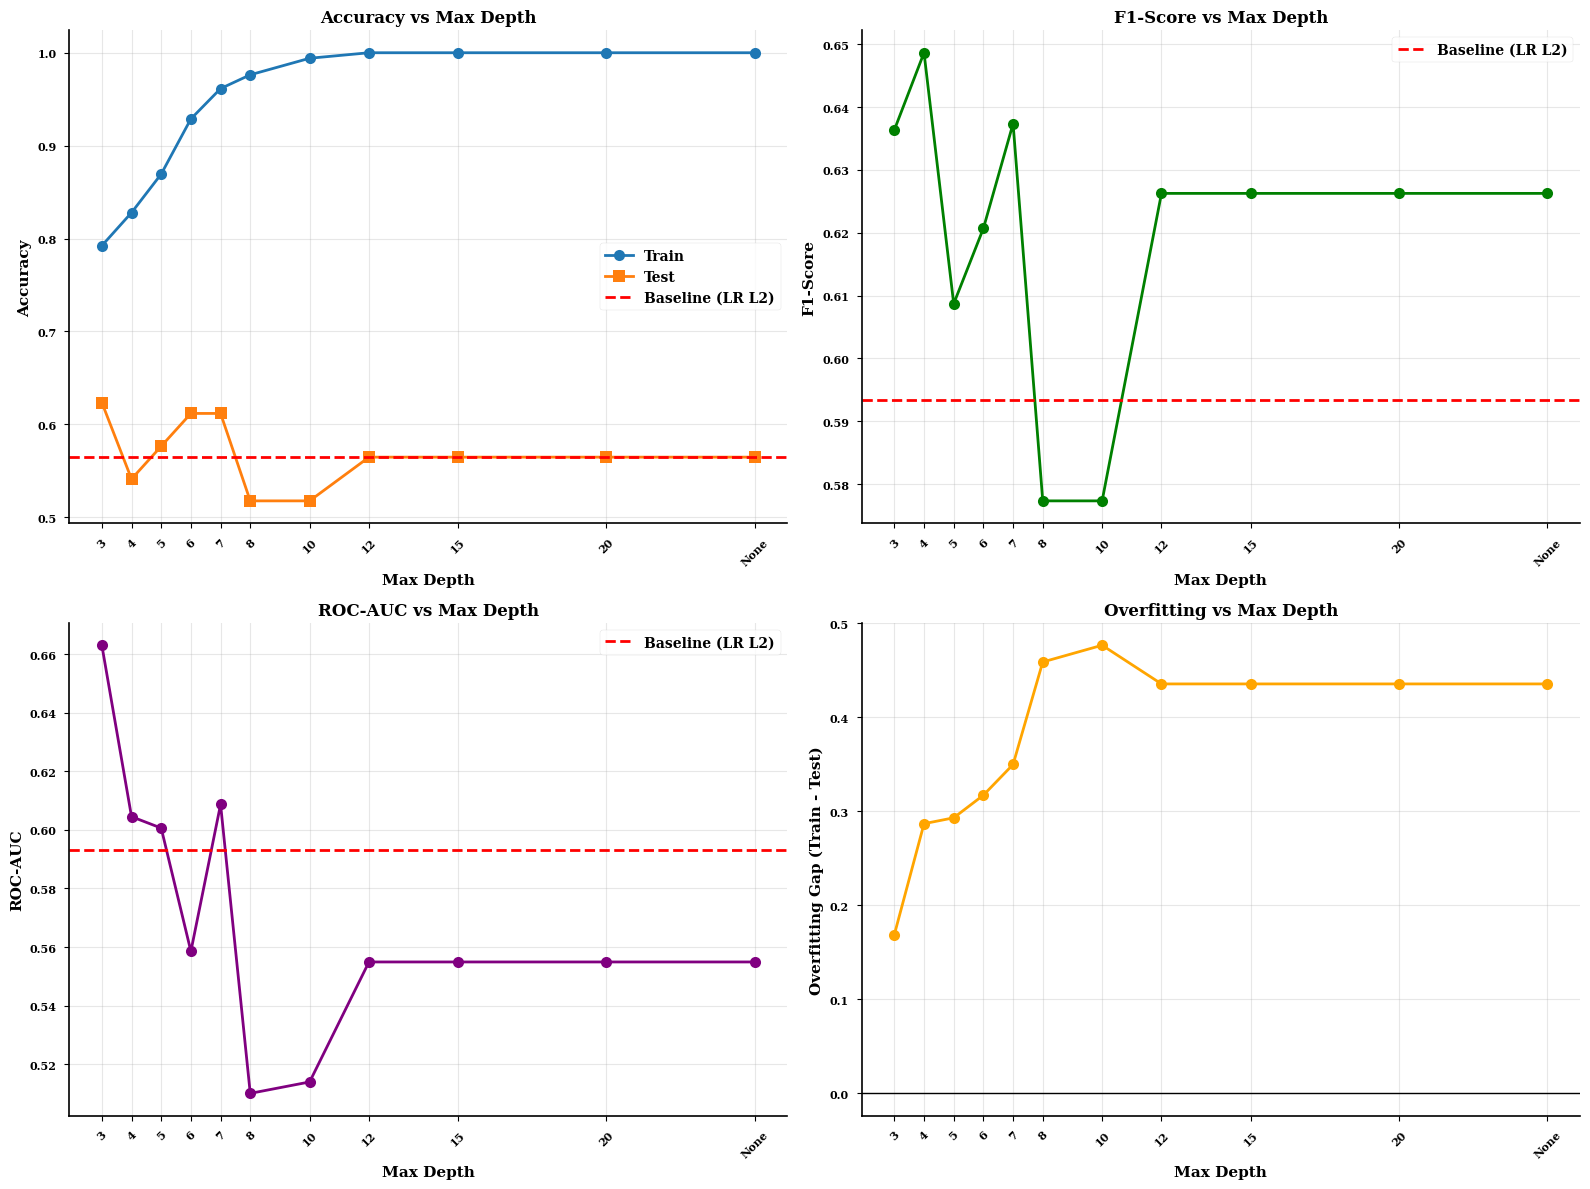


✓ Saved to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/decision_trees/depth_analysis.png


In [ ]:
# Plot depth analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Convert None to large number for plotting
plot_depths = [d if d != "None" else 25 for d in depth_df["max_depth"]]

# Plot 1: Accuracy vs Depth
axes[0, 0].plot(
    plot_depths, depth_df["train_acc"], "o-", linewidth=2, markersize=8, label="Train"
)
axes[0, 0].plot(
    plot_depths, depth_df["test_acc"], "s-", linewidth=2, markersize=8, label="Test"
)
axes[0, 0].axhline(
    y=baseline_results["lr_l2"]["test_accuracy"],
    color="red",
    linestyle="--",
    linewidth=2,
    label="Baseline (LR L2)",
)
axes[0, 0].set_xlabel("Max Depth", fontsize=11)
axes[0, 0].set_ylabel("Accuracy", fontsize=11)
axes[0, 0].set_title("Accuracy vs Max Depth", fontsize=12, fontweight="bold")
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_xticks(plot_depths)
axes[0, 0].set_xticklabels(
    [str(d) if d != "None" else "None" for d in depth_df["max_depth"]], rotation=45
)

# Plot 2: F1-score vs Depth
axes[0, 1].plot(
    plot_depths, depth_df["test_f1"], "o-", linewidth=2, markersize=8, color="green"
)
axes[0, 1].axhline(
    y=baseline_results["lr_l2"]["test_f1"],
    color="red",
    linestyle="--",
    linewidth=2,
    label="Baseline (LR L2)",
)
axes[0, 1].set_xlabel("Max Depth", fontsize=11)
axes[0, 1].set_ylabel("F1-Score", fontsize=11)
axes[0, 1].set_title("F1-Score vs Max Depth", fontsize=12, fontweight="bold")
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_xticks(plot_depths)
axes[0, 1].set_xticklabels(
    [str(d) if d != "None" else "None" for d in depth_df["max_depth"]], rotation=45
)

# Plot 3: ROC-AUC vs Depth
axes[1, 0].plot(
    plot_depths,
    depth_df["test_roc_auc"],
    "o-",
    linewidth=2,
    markersize=8,
    color="purple",
)
axes[1, 0].axhline(
    y=baseline_results["lr_l2"]["test_roc_auc"],
    color="red",
    linestyle="--",
    linewidth=2,
    label="Baseline (LR L2)",
)
axes[1, 0].set_xlabel("Max Depth", fontsize=11)
axes[1, 0].set_ylabel("ROC-AUC", fontsize=11)
axes[1, 0].set_title("ROC-AUC vs Max Depth", fontsize=12, fontweight="bold")
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_xticks(plot_depths)
axes[1, 0].set_xticklabels(
    [str(d) if d != "None" else "None" for d in depth_df["max_depth"]], rotation=45
)

# Plot 4: Overfitting Gap vs Depth
axes[1, 1].plot(
    plot_depths,
    depth_df["overfit_gap"],
    "o-",
    linewidth=2,
    markersize=8,
    color="orange",
)
axes[1, 1].axhline(y=0, color="black", linestyle="-", linewidth=1)
axes[1, 1].set_xlabel("Max Depth", fontsize=11)
axes[1, 1].set_ylabel("Overfitting Gap (Train - Test)", fontsize=11)
axes[1, 1].set_title("Overfitting vs Max Depth", fontsize=12, fontweight="bold")
axes[1, 1].grid(alpha=0.3)
axes[1, 1].set_xticks(plot_depths)
axes[1, 1].set_xticklabels(
    [str(d) if d != "None" else "None" for d in depth_df["max_depth"]], rotation=45
)

plt.tight_layout()
plt.savefig(dt_dir / "depth_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n✓ Saved to {dt_dir / 'depth_analysis.png'}")

## 9. Hyperparameter Tuning with Grid Search

Tune max_depth, min_samples_split, and min_samples_leaf using time-series cross-validation


In [ ]:
# Define parameter grid
param_grid = {
    "max_depth": [5, 6, 7, 8, 10],
    "min_samples_split": [20, 50, 100, 200],
    "min_samples_leaf": [10, 20, 50],
    "criterion": ["gini", "entropy"],
}

print("Hyperparameter tuning with GridSearchCV...")
print(f"Parameter grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")
print(f"\nTotal combinations: {np.prod([len(v) for v in param_grid.values()])}")

# Time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Grid search
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    param_grid=param_grid,
    cv=tscv,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train, y_train)

print("\n" + "=" * 80)
print("GRID SEARCH RESULTS")
print("=" * 80)
print(f"\nBest parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest cross-validation F1-score: {grid_search.best_score_:.4f}")

Hyperparameter tuning with GridSearchCV...
Parameter grid:
  max_depth: [5, 6, 7, 8, 10]
  min_samples_split: [20, 50, 100, 200]
  min_samples_leaf: [10, 20, 50]
  criterion: ['gini', 'entropy']

Total combinations: 120
Fitting 5 folds for each of 120 candidates, totalling 600 fits

GRID SEARCH RESULTS

Best parameters:
  criterion: entropy
  max_depth: 5
  min_samples_leaf: 10
  min_samples_split: 20

Best cross-validation F1-score: 0.6628


## 10. Train Final Tuned Model


In [ ]:
# Get best model from grid search
dt_tuned = grid_search.best_estimator_

# Predictions
y_train_pred_tuned = dt_tuned.predict(X_train)
y_test_pred_tuned = dt_tuned.predict(X_test)
y_test_proba_tuned = dt_tuned.predict_proba(X_test)[:, 1]

# Metrics
print("=" * 80)
print("TUNED DECISION TREE PERFORMANCE")
print("=" * 80)

print(f"\nTree structure:")
print(f"  Max depth: {dt_tuned.get_depth()}")
print(f"  Number of leaves: {dt_tuned.get_n_leaves()}")
print(f"  Min samples split: {dt_tuned.min_samples_split}")
print(f"  Min samples leaf: {dt_tuned.min_samples_leaf}")
print(f"  Criterion: {dt_tuned.criterion}")

print("\nTRAIN SET:")
print(f"  Accuracy:  {accuracy_score(y_train, y_train_pred_tuned):.4f}")
print(f"  Precision: {precision_score(y_train, y_train_pred_tuned):.4f}")
print(f"  Recall:    {recall_score(y_train, y_train_pred_tuned):.4f}")
print(f"  F1-score:  {f1_score(y_train, y_train_pred_tuned):.4f}")

print("\nTEST SET:")
test_acc_tuned = accuracy_score(y_test, y_test_pred_tuned)
test_f1_tuned = f1_score(y_test, y_test_pred_tuned)
test_auc_tuned = roc_auc_score(y_test, y_test_proba_tuned)

print(f"  Accuracy:  {test_acc_tuned:.4f}")
print(f"  Precision: {precision_score(y_test, y_test_pred_tuned):.4f}")
print(f"  Recall:    {recall_score(y_test, y_test_pred_tuned):.4f}")
print(f"  F1-score:  {test_f1_tuned:.4f}")
print(f"  ROC-AUC:   {test_auc_tuned:.4f}")

# Compare to baseline
print("\nIMPROVEMENT OVER BASELINE (Logistic Regression L2):")
acc_improvement = test_acc_tuned - baseline_results["lr_l2"]["test_accuracy"]
f1_improvement = test_f1_tuned - baseline_results["lr_l2"]["test_f1"]
auc_improvement = test_auc_tuned - baseline_results["lr_l2"]["test_roc_auc"]

print(
    f"  Accuracy:  {acc_improvement:+.4f} ({100*acc_improvement/baseline_results['lr_l2']['test_accuracy']:+.1f}%)"
)
print(
    f"  F1-score:  {f1_improvement:+.4f} ({100*f1_improvement/baseline_results['lr_l2']['test_f1']:+.1f}%)"
)
print(
    f"  ROC-AUC:   {auc_improvement:+.4f} ({100*auc_improvement/baseline_results['lr_l2']['test_roc_auc']:+.1f}%)"
)

TUNED DECISION TREE PERFORMANCE

Tree structure:
  Max depth: 5
  Number of leaves: 15
  Min samples split: 20
  Min samples leaf: 10
  Criterion: entropy

TRAIN SET:
  Accuracy:  0.7982
  Precision: 0.8457
  Recall:    0.7611
  F1-score:  0.8012

TEST SET:
  Accuracy:  0.5765
  Precision: 0.6042
  Recall:    0.6304
  F1-score:  0.6170
  ROC-AUC:   0.6324

IMPROVEMENT OVER BASELINE (Logistic Regression L2):
  Accuracy:  +0.0118 (+2.1%)
  F1-score:  +0.0236 (+4.0%)
  ROC-AUC:   +0.0393 (+6.6%)


## 11. Feature Importance Analysis


In [ ]:
# Get feature importance
feature_importance = pd.DataFrame(
    {"feature": feature_cols, "importance": dt_tuned.feature_importances_}
).sort_values("importance", ascending=False)

# Filter to non-zero importance
feature_importance_nonzero = feature_importance[feature_importance["importance"] > 0]

print("=" * 80)
print("FEATURE IMPORTANCE (TOP 20)")
print("=" * 80)
print(feature_importance.head(20).to_string(index=False))

print(f"\nFeatures used: {len(feature_importance_nonzero)}/{len(feature_cols)}")
print(
    f"Top 10 features account for {100*feature_importance.head(10)['importance'].sum():.1f}% of total importance"
)

FEATURE IMPORTANCE (TOP 20)
                       feature  importance
            agg_vwap_deviation    0.475479
                      agg_open    0.087878
impact_permanent_impact_5_mean    0.071661
              adv_volume_acf_1    0.068632
             adv_rv_scale_1min    0.062519
     cluster_inter_arrival_min    0.050495
          adv_variance_ratio_5    0.050369
      agg_volume_concentration    0.044883
                            mu    0.037116
            adv_rv_scale_10min    0.026009
             trade_trade_count    0.013560
                adv_vol_regime    0.011398
               adv_volume_kurt    0.000000
              adv_return_acf_5    0.000000
              adv_return_acf_1    0.000000
               adv_return_skew    0.000000
               adv_volume_skew    0.000000
               adv_return_kurt    0.000000
             adv_vol_ewma_slow    0.000000
             adv_vol_ewma_fast    0.000000

Features used: 12/81
Top 10 features account for 97.5% of total impo

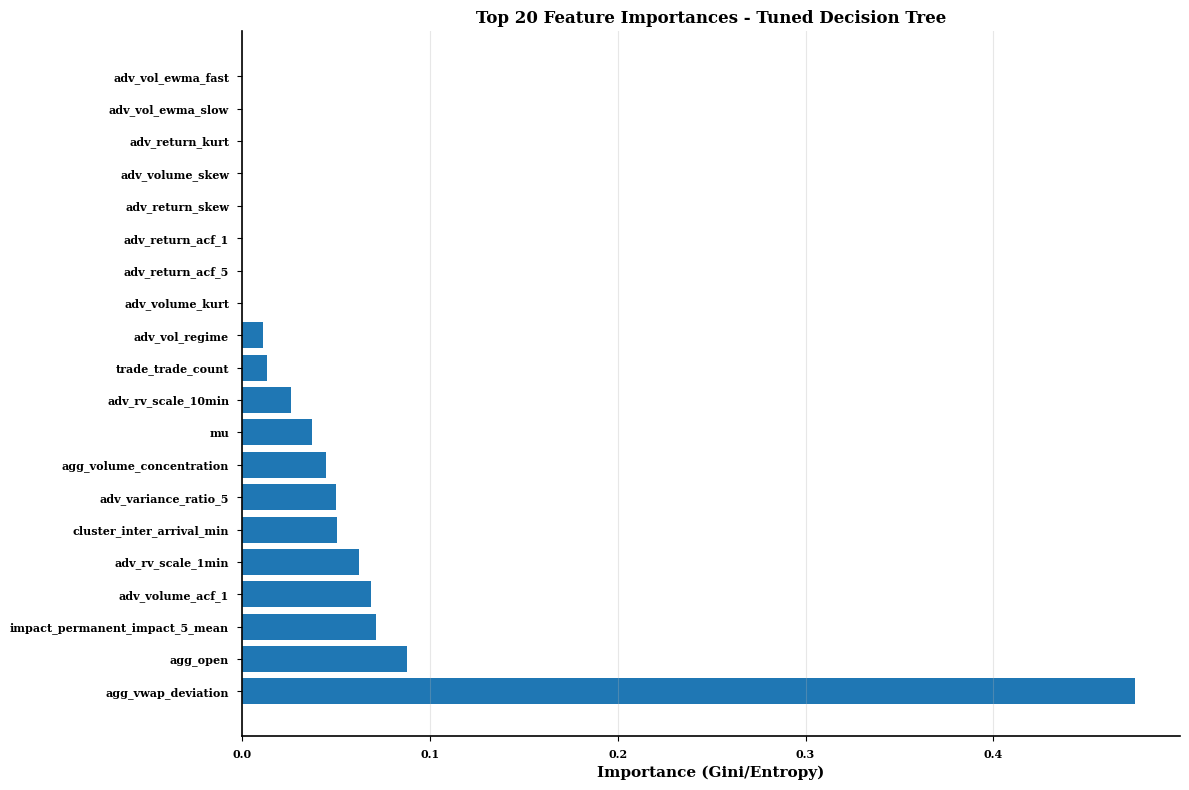


✓ Saved to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/decision_trees/feature_importance.png


In [ ]:
# Visualize feature importance
fig, ax = plt.subplots(figsize=(12, 8))

top_features = feature_importance.head(20)
ax.barh(range(len(top_features)), top_features["importance"].values)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features["feature"].values)
ax.set_xlabel("Importance (Gini/Entropy)", fontsize=11)
ax.set_title(
    "Top 20 Feature Importances - Tuned Decision Tree", fontsize=12, fontweight="bold"
)
ax.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.savefig(dt_dir / "feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n✓ Saved to {dt_dir / 'feature_importance.png'}")

## 12. Visualize Decision Tree

Visualize a simplified version of the tree (limited depth for readability)


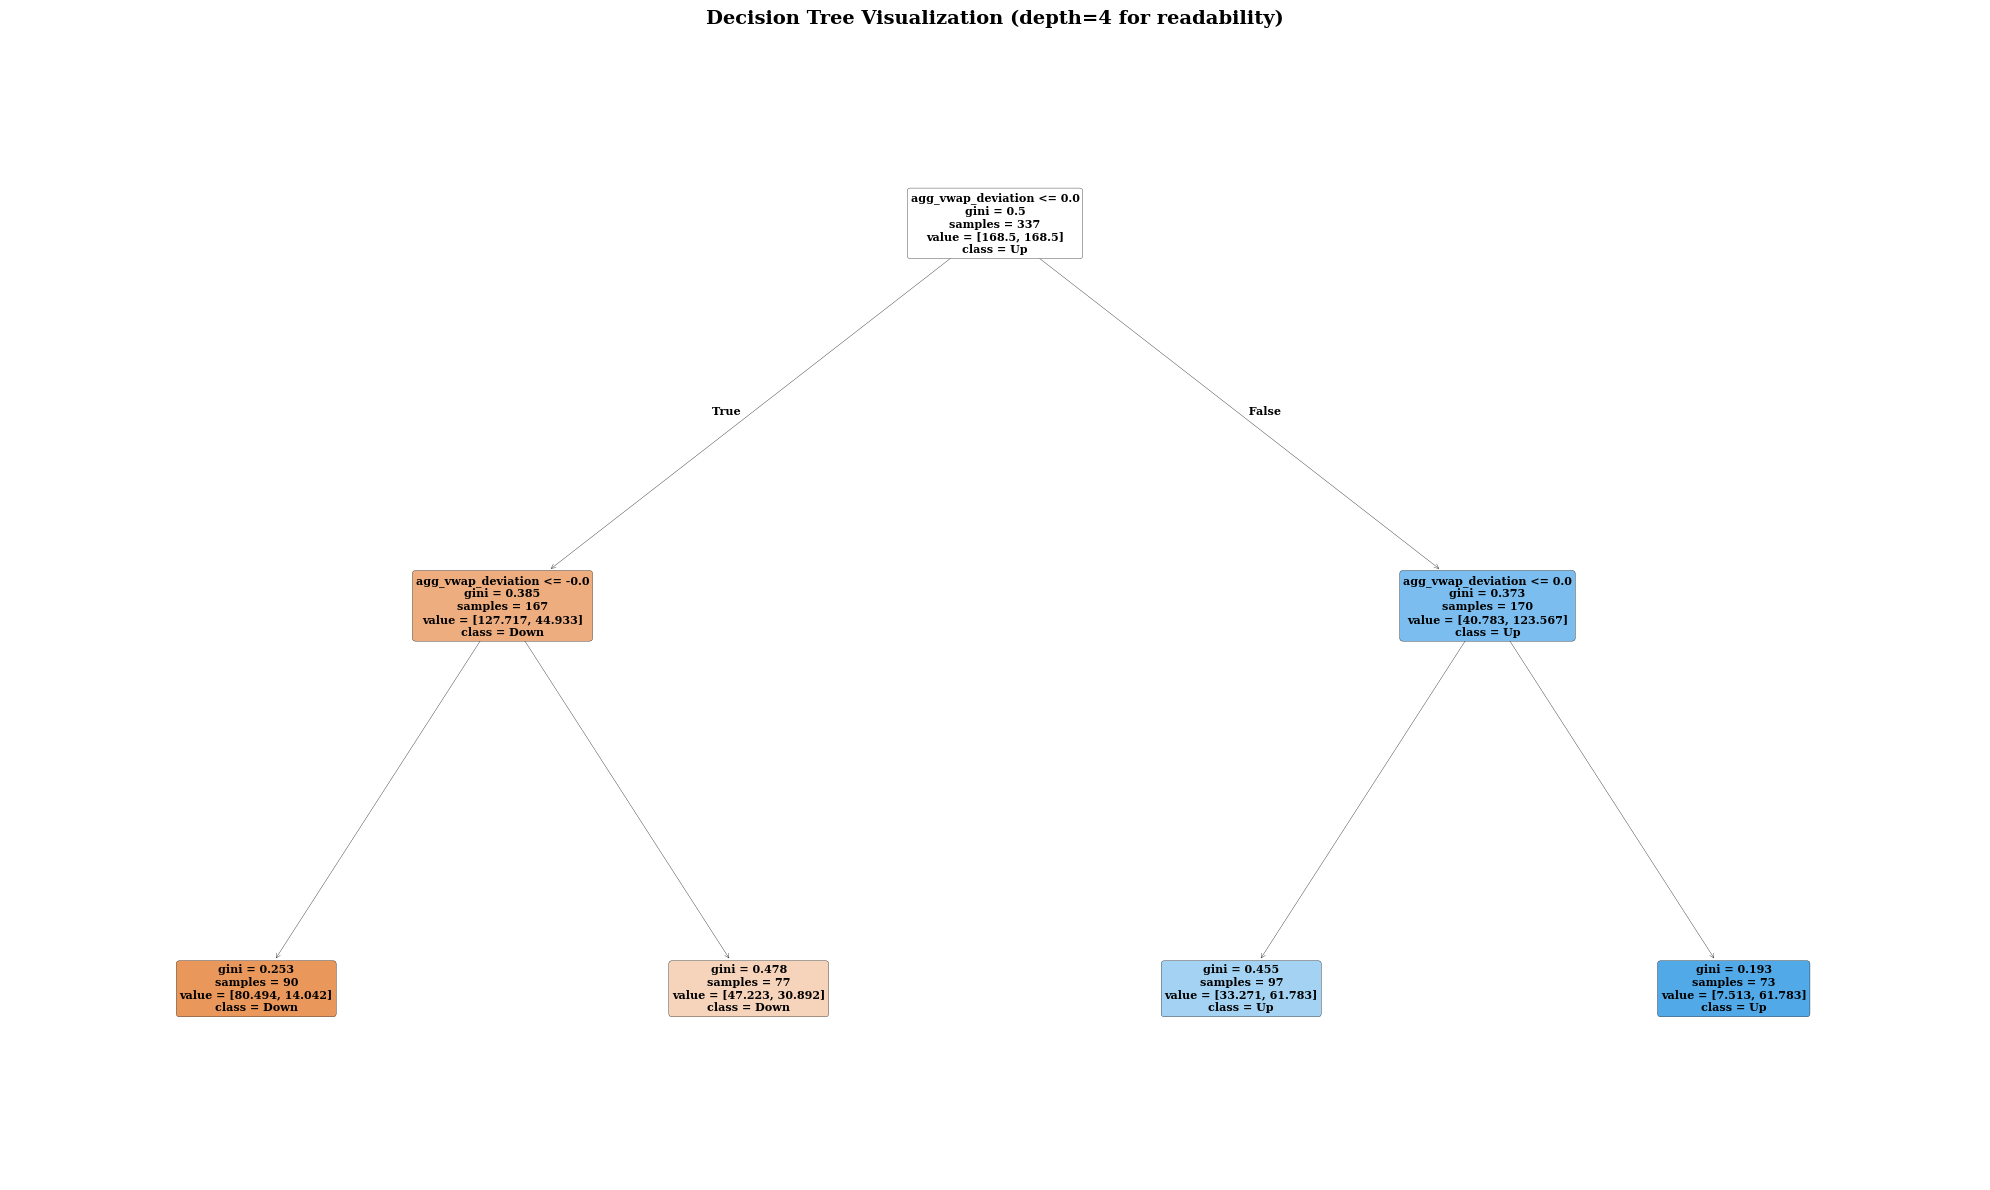


✓ Saved to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/decision_trees/tree_visualization.png

Note: Simplified tree (depth=4) shown for readability.
Actual tuned tree has depth=5


In [ ]:
# Train a smaller tree for visualization (max_depth=4)
dt_viz = DecisionTreeClassifier(
    max_depth=4,
    min_samples_split=100,
    min_samples_leaf=50,
    random_state=42,
    class_weight="balanced",
)

dt_viz.fit(X_train, y_train)

# Visualize tree
fig, ax = plt.subplots(figsize=(20, 12))
plot_tree(
    dt_viz,
    feature_names=feature_cols,
    class_names=["Down", "Up"],
    filled=True,
    rounded=True,
    fontsize=8,
    ax=ax,
)
ax.set_title(
    "Decision Tree Visualization (depth=4 for readability)",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.savefig(dt_dir / "tree_visualization.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n✓ Saved to {dt_dir / 'tree_visualization.png'}")
print(f"\nNote: Simplified tree (depth=4) shown for readability.")
print(f"Actual tuned tree has depth={dt_tuned.get_depth()}")

## 13. Extract Decision Rules


In [ ]:
# Export tree as text rules
tree_rules = export_text(dt_viz, feature_names=feature_cols, max_depth=3)

print("=" * 80)
print("DECISION RULES (simplified tree, depth=4, showing first 3 levels)")
print("=" * 80)
print(tree_rules)

# Save rules to file
with open(dt_dir / "decision_rules.txt", "w") as f:
    f.write(tree_rules)

print(f"\n✓ Full rules saved to {dt_dir / 'decision_rules.txt'}")

DECISION RULES (simplified tree, depth=4, showing first 3 levels)
|--- agg_vwap_deviation <= 0.00
|   |--- agg_vwap_deviation <= -0.00
|   |   |--- class: 0
|   |--- agg_vwap_deviation >  -0.00
|   |   |--- class: 0
|--- agg_vwap_deviation >  0.00
|   |--- agg_vwap_deviation <= 0.00
|   |   |--- class: 1
|   |--- agg_vwap_deviation >  0.00
|   |   |--- class: 1


✓ Full rules saved to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/decision_trees/decision_rules.txt


## 14. Confusion Matrix and ROC Curve


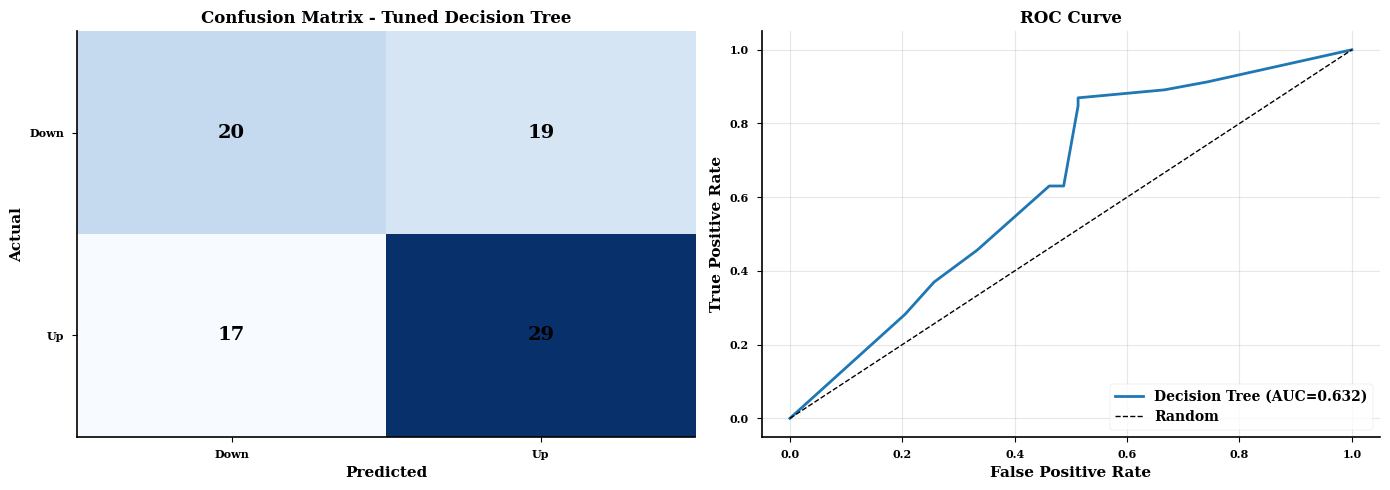


✓ Saved to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/decision_trees/performance.png


In [ ]:
# Create performance visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred_tuned)
im = axes[0].imshow(cm, cmap="Blues", aspect="auto")
axes[0].set_title(
    "Confusion Matrix - Tuned Decision Tree", fontsize=12, fontweight="bold"
)
axes[0].set_xlabel("Predicted", fontsize=11)
axes[0].set_ylabel("Actual", fontsize=11)
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(["Down", "Up"])
axes[0].set_yticklabels(["Down", "Up"])

# Annotate cells
for row in range(2):
    for col in range(2):
        axes[0].text(
            col,
            row,
            str(cm[row, col]),
            ha="center",
            va="center",
            fontsize=14,
            fontweight="bold",
        )

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba_tuned)
axes[1].plot(fpr, tpr, linewidth=2, label=f"Decision Tree (AUC={test_auc_tuned:.3f})")
axes[1].plot([0, 1], [0, 1], "k--", linewidth=1, label="Random")
axes[1].set_xlabel("False Positive Rate", fontsize=11)
axes[1].set_ylabel("True Positive Rate", fontsize=11)
axes[1].set_title("ROC Curve", fontsize=12, fontweight="bold")
axes[1].legend(loc="lower right", fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(dt_dir / "performance.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n✓ Saved to {dt_dir / 'performance.png'}")

## 15. Save Models and Results


In [ ]:
# Save models
with open(MODELS_DIR / "decision_tree_tuned.pkl", "wb") as f:
    pickle.dump(dt_tuned, f)
with open(MODELS_DIR / "decision_tree_baseline.pkl", "wb") as f:
    pickle.dump(dt_baseline, f)

print("✓ Models saved:")
print(f"  {MODELS_DIR / 'decision_tree_tuned.pkl'}")
print(f"  {MODELS_DIR / 'decision_tree_baseline.pkl'}")

✓ Models saved:
  /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../models/decision_tree_tuned.pkl
  /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../models/decision_tree_baseline.pkl


In [ ]:
# Save results
results = {
    "dt_baseline": {
        "train_accuracy": float(accuracy_score(y_train, y_train_pred_base)),
        "test_accuracy": float(accuracy_score(y_test, y_test_pred_base)),
        "test_precision": float(precision_score(y_test, y_test_pred_base)),
        "test_recall": float(recall_score(y_test, y_test_pred_base)),
        "test_f1": float(f1_score(y_test, y_test_pred_base)),
        "test_roc_auc": float(roc_auc_score(y_test, y_test_proba_base)),
        "tree_depth": int(dt_baseline.get_depth()),
        "n_leaves": int(dt_baseline.get_n_leaves()),
    },
    "dt_tuned": {
        "train_accuracy": float(accuracy_score(y_train, y_train_pred_tuned)),
        "test_accuracy": float(test_acc_tuned),
        "test_precision": float(precision_score(y_test, y_test_pred_tuned)),
        "test_recall": float(recall_score(y_test, y_test_pred_tuned)),
        "test_f1": float(test_f1_tuned),
        "test_roc_auc": float(test_auc_tuned),
        "tree_depth": int(dt_tuned.get_depth()),
        "n_leaves": int(dt_tuned.get_n_leaves()),
        "best_params": grid_search.best_params_,
        "cv_f1_score": float(grid_search.best_score_),
    },
    "improvement_over_baseline": {
        "accuracy": float(acc_improvement),
        "f1": float(f1_improvement),
        "roc_auc": float(auc_improvement),
        "accuracy_pct": float(
            100 * acc_improvement / baseline_results["lr_l2"]["test_accuracy"]
        ),
        "f1_pct": float(100 * f1_improvement / baseline_results["lr_l2"]["test_f1"]),
        "roc_auc_pct": float(
            100 * auc_improvement / baseline_results["lr_l2"]["test_roc_auc"]
        ),
    },
    "depth_analysis": depth_df.to_dict("records"),
}

with open(MODELS_DIR / "decision_tree_results.json", "w") as f:
    json.dump(results, f, indent=2)

print(f"\n✓ Results saved to {MODELS_DIR / 'decision_tree_results.json'}")


✓ Results saved to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../models/decision_tree_results.json


In [ ]:
# Save feature importance
feature_importance.to_csv(TABLES_DIR / "dt_feature_importance.csv", index=False)
depth_df.to_csv(TABLES_DIR / "dt_depth_analysis.csv", index=False)

print("✓ Tables saved:")
print(f"  {TABLES_DIR / 'dt_feature_importance.csv'}")
print(f"  {TABLES_DIR / 'dt_depth_analysis.csv'}")

✓ Tables saved:
  /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/tables/dt_feature_importance.csv
  /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/tables/dt_depth_analysis.csv


## 16. Summary


In [ ]:
print("=" * 80)
print("DECISION TREE ANALYSIS SUMMARY")
print("=" * 80)

print(f"\nData:")
print(f"  Train samples: {len(X_train):,}")
print(f"  Test samples: {len(X_test):,}")
print(f"  Features: {len(feature_cols)}")

print(f"\nBaseline Decision Tree (default parameters):")
print(f"  Test Accuracy: {results['dt_baseline']['test_accuracy']:.4f}")
print(f"  Test F1-score: {results['dt_baseline']['test_f1']:.4f}")
print(f"  Test ROC-AUC:  {results['dt_baseline']['test_roc_auc']:.4f}")
print(f"  Tree depth: {results['dt_baseline']['tree_depth']}")
print(f"  Number of leaves: {results['dt_baseline']['n_leaves']}")

print(f"\nTuned Decision Tree:")
print(f"  Test Accuracy: {results['dt_tuned']['test_accuracy']:.4f}")
print(f"  Test F1-score: {results['dt_tuned']['test_f1']:.4f}")
print(f"  Test ROC-AUC:  {results['dt_tuned']['test_roc_auc']:.4f}")
print(f"  Tree depth: {results['dt_tuned']['tree_depth']}")
print(f"  Number of leaves: {results['dt_tuned']['n_leaves']}")

print(f"\nBest Hyperparameters:")
for param, value in results["dt_tuned"]["best_params"].items():
    print(f"  {param}: {value}")

print(f"\nImprovement over Baseline (Logistic Regression L2):")
print(
    f"  Accuracy:  {results['improvement_over_baseline']['accuracy']:+.4f} ({results['improvement_over_baseline']['accuracy_pct']:+.1f}%)"
)
print(
    f"  F1-score:  {results['improvement_over_baseline']['f1']:+.4f} ({results['improvement_over_baseline']['f1_pct']:+.1f}%)"
)
print(
    f"  ROC-AUC:   {results['improvement_over_baseline']['roc_auc']:+.4f} ({results['improvement_over_baseline']['roc_auc_pct']:+.1f}%)"
)

print(f"\nKey Insights:")
print(
    f"  - Decision Tree {'outperforms' if test_acc_tuned > baseline_results['lr_l2']['test_accuracy'] else 'underperforms'} logistic regression baseline"
)
print(f"  - Optimal depth found at {optimal_depth} (performance saturates beyond this)")
print(
    f"  - {len(feature_importance_nonzero)} features used out of {len(feature_cols)} available"
)
print(
    f"  - Top 10 features account for {100*feature_importance.head(10)['importance'].sum():.1f}% of importance"
)

print(f"\nNext Steps:")
print(f"  - Notebook 45: Random Forest (ensemble of trees)")
print(f"  - Notebook 50: Gradient Boosting (sequential boosting)")
print(f"  - Compare ensemble methods vs. single tree performance")

print("\n" + "=" * 80)

DECISION TREE ANALYSIS SUMMARY

Data:
  Train samples: 337
  Test samples: 85
  Features: 81

Baseline Decision Tree (default parameters):
  Test Accuracy: 0.5647
  Test F1-score: 0.6263
  Test ROC-AUC:  0.5549
  Tree depth: 12
  Number of leaves: 61

Tuned Decision Tree:
  Test Accuracy: 0.5765
  Test F1-score: 0.6170
  Test ROC-AUC:  0.6324
  Tree depth: 5
  Number of leaves: 15

Best Hyperparameters:
  criterion: entropy
  max_depth: 5
  min_samples_leaf: 10
  min_samples_split: 20

Improvement over Baseline (Logistic Regression L2):
  Accuracy:  +0.0118 (+2.1%)
  F1-score:  +0.0236 (+4.0%)
  ROC-AUC:   +0.0393 (+6.6%)

Key Insights:
  - Decision Tree outperforms logistic regression baseline
  - Optimal depth found at 4 (performance saturates beyond this)
  - 12 features used out of 81 available
  - Top 10 features account for 97.5% of importance

Next Steps:
  - Notebook 45: Random Forest (ensemble of trees)
  - Notebook 50: Gradient Boosting (sequential boosting)
  - Compare ensem